# Twords 

This notebook will show a typical work flow when using Twords to analyze word frequencies of twitter data. 

The basic work flow is you search twitter for a particular search term, say "charisma", either with the java search function or with the Twitter API. (Note: for more obscure terms like "charisma", an API search may take upwards of a day or two to get a reasonable sized data set. The java search code would be much faster in these cases.) All the returned tweets are then put into a bag-of-words frequency analyzer to find the frequency of each word in collection of tweets. These frequencies are compared with the background frequencies of English words on twitter (there are several options for computing this background rate, see below) and the results displayed in order of which words are most disproportionately more frequently used with that search. 

E.g., if you search for "charisma", you will find that words like "great", "lacks", and "handsome" were roughly 20 times more likely to occur in tweets with the word "charisma" in it than in a random sample of all tweets. Twords creates a list of these disproportionately-used words, in order of how many times more likely they are to appear in tweets containing search term that otherwise. 

Once the frequency chart is found with the list of disproportionately used words, the user can search the tweet corpus for tweets containing one of these words to see what types of tweets had them. In the charisma example, it was found that "carpenter" was one of the most common words in these tweets, but a search in the tweet corpus revealed that a popular actress was named "charisma carpenter", so all tweets about her were included. Since this was not the sense that was intended, Twords lets the user delete tweets from the corpus by search term and re-do the frequency analysis. In this case, tweets containing the word "carpenter" were removed. (This would also remove a tweet that said something like "the carpenter I hired had great charisma", which we would probably want to include in the corpus, but this is a small price to pay to remove the many unwanted "charisma carpenter" tweets.) Another common use of this delete function is to remove spam - spam often consists of idential tweets coming simultaneously from several different accounts, which can produce noticeable (and probably undesired) frequency associations in the final bag-of-words analysis.

### Main objects within Twords class: 

**data_path**: Path to twitter data collected with search_terms. Currently code is meant to read in data collected wtih Henrique twitter code. 

**background_path**: path to background twitter data used to compare word frequencies 

**search_terms**: list of terms used in twitter search to collect tweets located at data_path 

**tweets_df**: pandas dataframe that contains all tweets located at data_path, possibly with some tweets dropped (see  dropping methods below). If user needs to re-add tweets that were previously dropped they must reload all tweet data over again from the csv. 

**word_bag**: python list of words in all tweets contained in tweets_df

**freq_dist**: nltk.FreqDist() object computed on word_bag

**word_freq_df**: pandas dataframe of frequencies of top words computed from freq_dist


The two most important objects are **tweets_df** and **word_freq_df**, the dataframes that hold the tweets themselves and the relative frequencies of words in those tweets.

## Note on background word frequencies 

If the search is done by the Twitter API, calculation of background word frequencies is straightforward with the sampling feature of the Twitter API. 

If the tweets are gathered using the java search code (which queries twitter automatically through Twitter's web interface), background frequencies can be trickier, since the java library can specify search dates. Search dates set a year or more in the past in principle require background rates for those past dates, which cannot be obtained with the Twitter API. To approximate these rates, a search was done using ~50 of the most common English words simultaneously. 

Another issue is that the java code can return either "top tweets" only or "all tweets" for a given search term, depending on which jar file is used.

A solution is to use all three background possibilities (current API background, Top tweets background w/ top 50 English search terms, and All tweets background with top 50 English search terms) and compare their word rates each other. In early versions of these tests the difference in word rates in background between Twitter API and Top tweets was typically less than factor of 2, which would make little difference in word rates comparison, as words of interest typically appeared ~10 or more times more frequently than base rate. 

# Example using search on word "charisma"
Showing how program can work with some previously collected tweets. These were found by searching for "charisma" and "charismatic" using java code, i.e. by calling create_java_tweets in Twords. The create_java_tweets function can return ~2000 tweets per minute, which is much faster than the Twitter API when searching for uncommon words like "charisma."

In [1]:
# to reload files that are changed automatically
%load_ext autoreload
%autoreload 2

In [2]:
from twords.twords import Twords 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
# this pandas line makes the dataframe display all text in a line; useful for seeing entire tweets
pd.set_option('display.max_colwidth', -1)

First set path to desired twitter data location, collect tweets, lower case of all letters, and drop tweets where the strings "charisma" or "charismatic" are contained in either a username or a mention. 

## Example with pre-existing data collected with Twords

In [3]:
twit = Twords()
twit.data_path = "data/java_collector/charisma_300000"
twit.background_path = 'jar_files_and_background/freq_table_72319443_total_words_twitter_corpus.csv'
twit.create_Background_dict()
twit.set_Search_terms(["charisma"])
twit.create_Stop_words()

In [4]:
twit.get_java_tweets_from_csv_list()

In [5]:
# find how many tweets we have in original dataset
print "Total number of tweets:", len(twit.tweets_df)

Total number of tweets: 267917


## Do standard cleaning

In [6]:
twit.lower_tweets()

In [7]:
# for this data set this drops about 200 tweets
twit.keep_only_unicode_tweet_text()

In [8]:
twit.remove_urls_from_tweets()

Removing urls from tweets...
This may take a minute - cleaning rate is about 400,000 tweets per minute
Time to complete: 0.626 minutes
Tweets cleaned per minute: 427615.7


In [9]:
twit.convert_tweet_dates_to_standard()

In [10]:
twit.sort_tweets_by_date()

In [11]:
# these will also commonly be used for collected tweets - DROP DUPLICATES and DROP BY SEARCH IN NAME
twit.drop_duplicates_in_text()

In [12]:
twit.drop_by_search_in_name()

In [13]:
# apparently not all tweets contain the word "charisma" at this point, so do this
# cleaning has already dropped about half of the tweets we started with 
len(twit.tweets_df)

137984

In [14]:
twit.keep_tweets_with_terms("charisma")

In [15]:
len(twit.tweets_df)

126025

## Create the word bag and then the nltk object from the tweets in tweets_df

In [16]:
twit.create_word_bag()
twit.make_nltk_object_from_word_bag()

Time to make words_string:  0.001 minutes
Time to tokenize:  0.754 minutes
Time to compute word bag:  0.209 minutes


## Create dataframe showing the most common words in the tweets and plot the results

Ideally word_freq_df would be created with a large number like 10,000, since it is created in order of most common words in the corpus, and the more interesting relative frequencies may occur with less-common words. It takes about one minutes to compute per 1000 words though, so as a first look at data it can make sense to create with smaller values of n. Here we'll use n=400.

In [17]:
# this creates twit.word_freq_df, a dataframe that stores word frequency values
twit.create_word_freq_df(400)

Creating word_freq_df...
Takes about 1 minute per 1000 words
Time to create word_freq_df:  0.2785 minutes


In [18]:
twit.word_freq_df.sort_values("log relative frequency", ascending = True, inplace = True)

In [19]:
twit.word_freq_df.head()

,word,occurrences,frequency,relative frequency,log relative frequency,background_occur
111,``,902,0.000743,0.171561,-1.762818,313137
338,free,418,0.000344,0.234322,-1.451058,106245
283,thanks,466,0.000384,0.270039,-1.309188,102779
116,today,882,0.000726,0.323247,-1.129340,162510
341,follow,413,0.000340,0.326585,-1.119064,75318


Instead of using plotting function provided by Twords we'll manipulate the word_freq_df dataframe directly - remember, don't get stuck in API bondage!

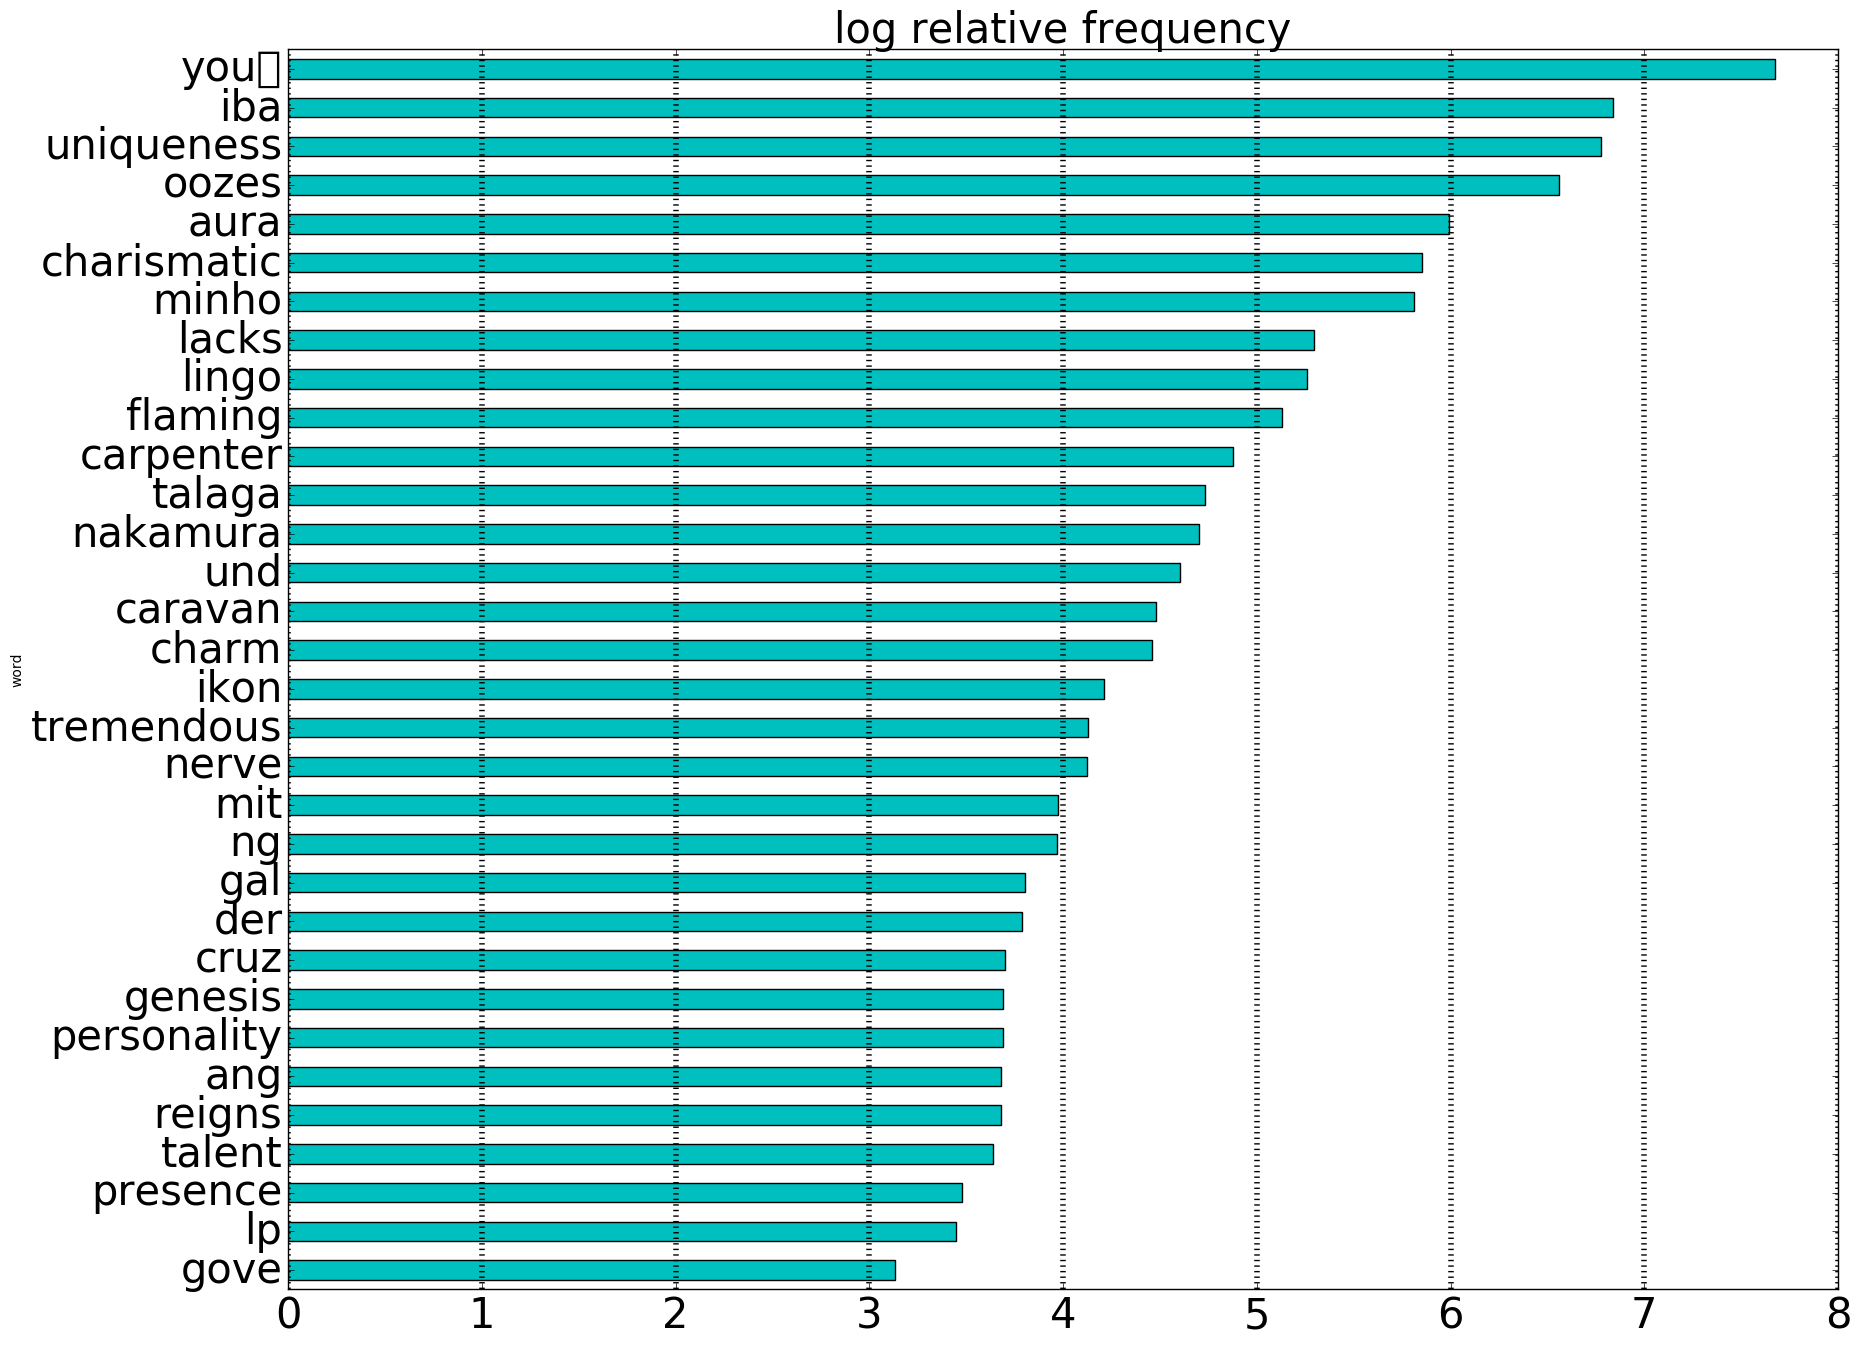

In [21]:
num_words_to_plot = 32
twit.word_freq_df.set_index("word")["log relative frequency"][-num_words_to_plot:].plot.barh(figsize=(20,
                num_words_to_plot/2.), fontsize=30, color="c"); 
plt.title("log relative frequency", fontsize=30); 
ax = plt.axes();        
ax.xaxis.grid(linewidth=4);

# Further data cleaning

The typical Twords workflow is to collect tweets, load them into tweets_df, do preliminary cleaning, create word_freq_df to look at relative word frequencies, and then depending on any potential/undesired effects seen in data, further filter tweets_df and recreate word_freq_df until the data is cleaned sufficiently to be of use.

The next section shows how this process can work.

## Fighting spam and unusually high relative frequencies

Repetitive non-desired tweets are the number one problem in interpreting results, as large numbers of tweets that use same phrase causes various non-relevant words to appear high in word_freq_df. Sometimes the problem is spam accounts doing advertising, sometimes it is a pop culture phenomenon that many different users are quoting: e.g. people enjoy quoting the line 'excuse my charisma' from the song "6 Foot 7 Foot" by Lil Wayne on Twitter, which means "excuse" appears much more frequently than background when searching for "charisma," even though this does not reveal something semantically interesting about the word "charisma." The problem is at its worst when the problem-word is rare in the background, which causes it to have a huge relative frequency.

When looking through the chart of extra-frequent words it is good to check which kinds of tweets those words are appearing in to be sure they are relevant to your search.

## Best defense against spammy/repetitive tweets: large dataset that spans several years

A huge dataset of several million tweets is best for averaging over time periods where different phrases become popular. When this isn't possible (or even when it is), the tools below can help to filter out spammy/repetitive tweets from dataset.

## Second best defense: choose higher threshold for background occurrences

It is a good idea to create a large word_freq_df with the top 10,000 or so words once and then investigate further. One problem that can occur is when the relative frequency for a word (below, we'll see this problem for a word like "minho") is huge because the background value is tiny - we can filter out cases like this by filtering word_freq_df to only include words with a high cutoff background frequency.

### Investigating data

#### Note: this investigation was done using word_freq_df with 400 words - only top 30 are shown in graphics here so that notebook can be viewed reasonably on Github

The first word "you!" is quite interesting - it looks like people frequently use the terms "charisma" as a direct compliment to someone else, as the tweets below show.

In [22]:
twit.tweets_containing("you!").head(12)

193 tweets contain this term


,username,text
515,foccatsrescue,charisma was adopted! her new family!!!! thank you!!!
1096,gaibriul,@enzodiacyt dude! i love you! but i just can't see it. i don't feel like i have any charisma infront of the camera atm.
1158,allanpcmln,@annvalenciaa thank you baby!! iba kasi talaga charisma mo hmp. i love you!
1371,videostreams,the magnetic personality formula: this video reveals the truth about charisma that nobody has ever told you! #video
1962,thenextfivver,the magnetic personality formula: this video reveals the truth about charisma that nobody has ever told you!
2029,tammyhillier,@alancross thank you!! i also don't get the hype .. never have. my big toe has more charisma!!
2312,biancarosemodel,@msveronicabound thank you!! i loved working with you too <3 you have awesome charisma and pack quite a wallop! can't wait till next time :*
2859,charis_precious,you can deceive many with your charisma but your fruits will expose you!
3493,mshecyclist,oo nahhh oo nahhh! ikaw talaga divina ang nagdadala. bilib na talaga kami sa'yong charisma. hehehe aldub you! #aldub31stweeksary
4021,albonhugs,"@thetwinsyoutube you make me smile- you've become one of my best friends and i can't wait to meet you! love you so much, charisma!"


For the word "iba", we appear to be finding tweets that are not in English. These are good candidates to drop if we only want English words. (There is a python library called langdetect that can classify languages of tweets quite well - the problem is it can only classify ~2500 tweets per minute, which is rather slow for one machine. An example will be given below of how to use it if that is desired.)

In [23]:
twit.tweets_containing(" iba ").head(12)

447 tweets contain this term


,username,text
196,aniger_eyaf,dude believe me iba charisma ni regina faye educalane ... diba diba @alyzzarobles97 @ellsmayo @lalalacielo @cathlenecanlas @mawyeeel
433,rhinazipagan,o m g! iba tlg ang charisma ni mengs! onelove adn #votemainefpp #kca
965,francesdyan,haha! iba charisma ng aso may baby clarky na ang #jadine. then may baby monkey na ang #lizquen dolceamore on ratedk
1158,allanpcmln,@annvalenciaa thank you baby!! iba kasi talaga charisma mo hmp. i love you!
1189,gianinadlgomez,"marlou yan eh, iba talaga charisma #ggvfebibigwins"
1263,thirdy333333,@justjunius iba talaga ang charisma. leche ka.
1470,pqmaricar26,@tintwirl hahaha iba talaha charisma ni quen hindi pahihindian #dolceamoresweetbeginning
1488,_jungjaehyuns,@kallaseu hahaha im a ten biased pero si taeyong iba ang charisma!!!!
1716,bebethbajada,#votemainefpp #kca even the mid 50's me kilig pdn pala hahaha iba talaga ang charisma ng aldub kasama ang aldubnation wow!
1723,mylzperhour,@mrkimpson_ super... iba yung charisma ni @jojeol & iu


Another example we probably wish to drop is tweets containing "carpenter", because these overwhelmingly refer to the actress Charisma Carpenter:

In [24]:
twit.tweets_containing("carpenter").head(12)

1195 tweets contain this term


,username,text
27,shirodesudesu,could i just have a whole series based off that witch couple in supernatural with james marsters and charisma carpenter? #alliveeverwanted
57,corralantonello,"buffy the vampire slayer angel slave cordelia 6 figure new charisma carpenter ?ff3=2&toolid=10039&campid=5337597384&item=331777331777&vectorid=229466&lgeo=1 …pic.twitter.com/mfjrl8xsbo"""
129,dogbr0ther,@larsenbryce @ryanhigginsryan you have slowly won me over. you are the king of charisma. unfortunately not charisma carpenter.
465,nissemus,@socialsoprano is that charisma carpenter?
712,emwendorf,what joss whedon did to charisma carpenter/cordy (2002-2003).
998,ndeddiemac,didn’t statham have charisma carpenter in ex2? live your life buddy #eddiedrunjflix
1039,livingforce06,charisma carpenter - bound (2015) …
1041,elektrashearts,charisma carpenter is in this episode too wow pic.twitter.com/wxbtrtzovd
1071,alineteston,honestly i'm kinda happy that charisma carpenter's character will show some interest in jay. at this point i'll take anything! #chicagopd
1091,proudlovatjc,"certo che charisma carpenter è proprio un vampiro, oh"


We find a similar thing when looking at tweets containing "minho" and "flaming": the Korean singer "Minho" has the nickname "Flaming Charisma", which is also not what we're interested in.

Thus we see we should drop tweets containing " iba ", "minho", "flaming", and "carpenter" from tweets_df. We do this and then recalculate word statistics: 

In [25]:
twit.drop_by_term_in_tweet([" iba ", "minho", "flaming", "carpenter"])

Now recalculate word bag and word frequency object:

In [26]:
# recompute word bag for word statistics
twit.create_word_bag()
twit.make_nltk_object_from_word_bag()

Time to make words_string:  0.001 minutes
Time to tokenize:  0.687 minutes
Time to compute word bag:  0.2 minutes


In [27]:
# create word frequency dataframe
twit.create_word_freq_df(400)

Creating word_freq_df...
Takes about 1 minute per 1000 words
Time to create word_freq_df:  0.2857 minutes


In [28]:
# plot new results - again, only showing top 30 here
twit.word_freq_df.sort_values("log relative frequency", ascending = True, inplace = True)

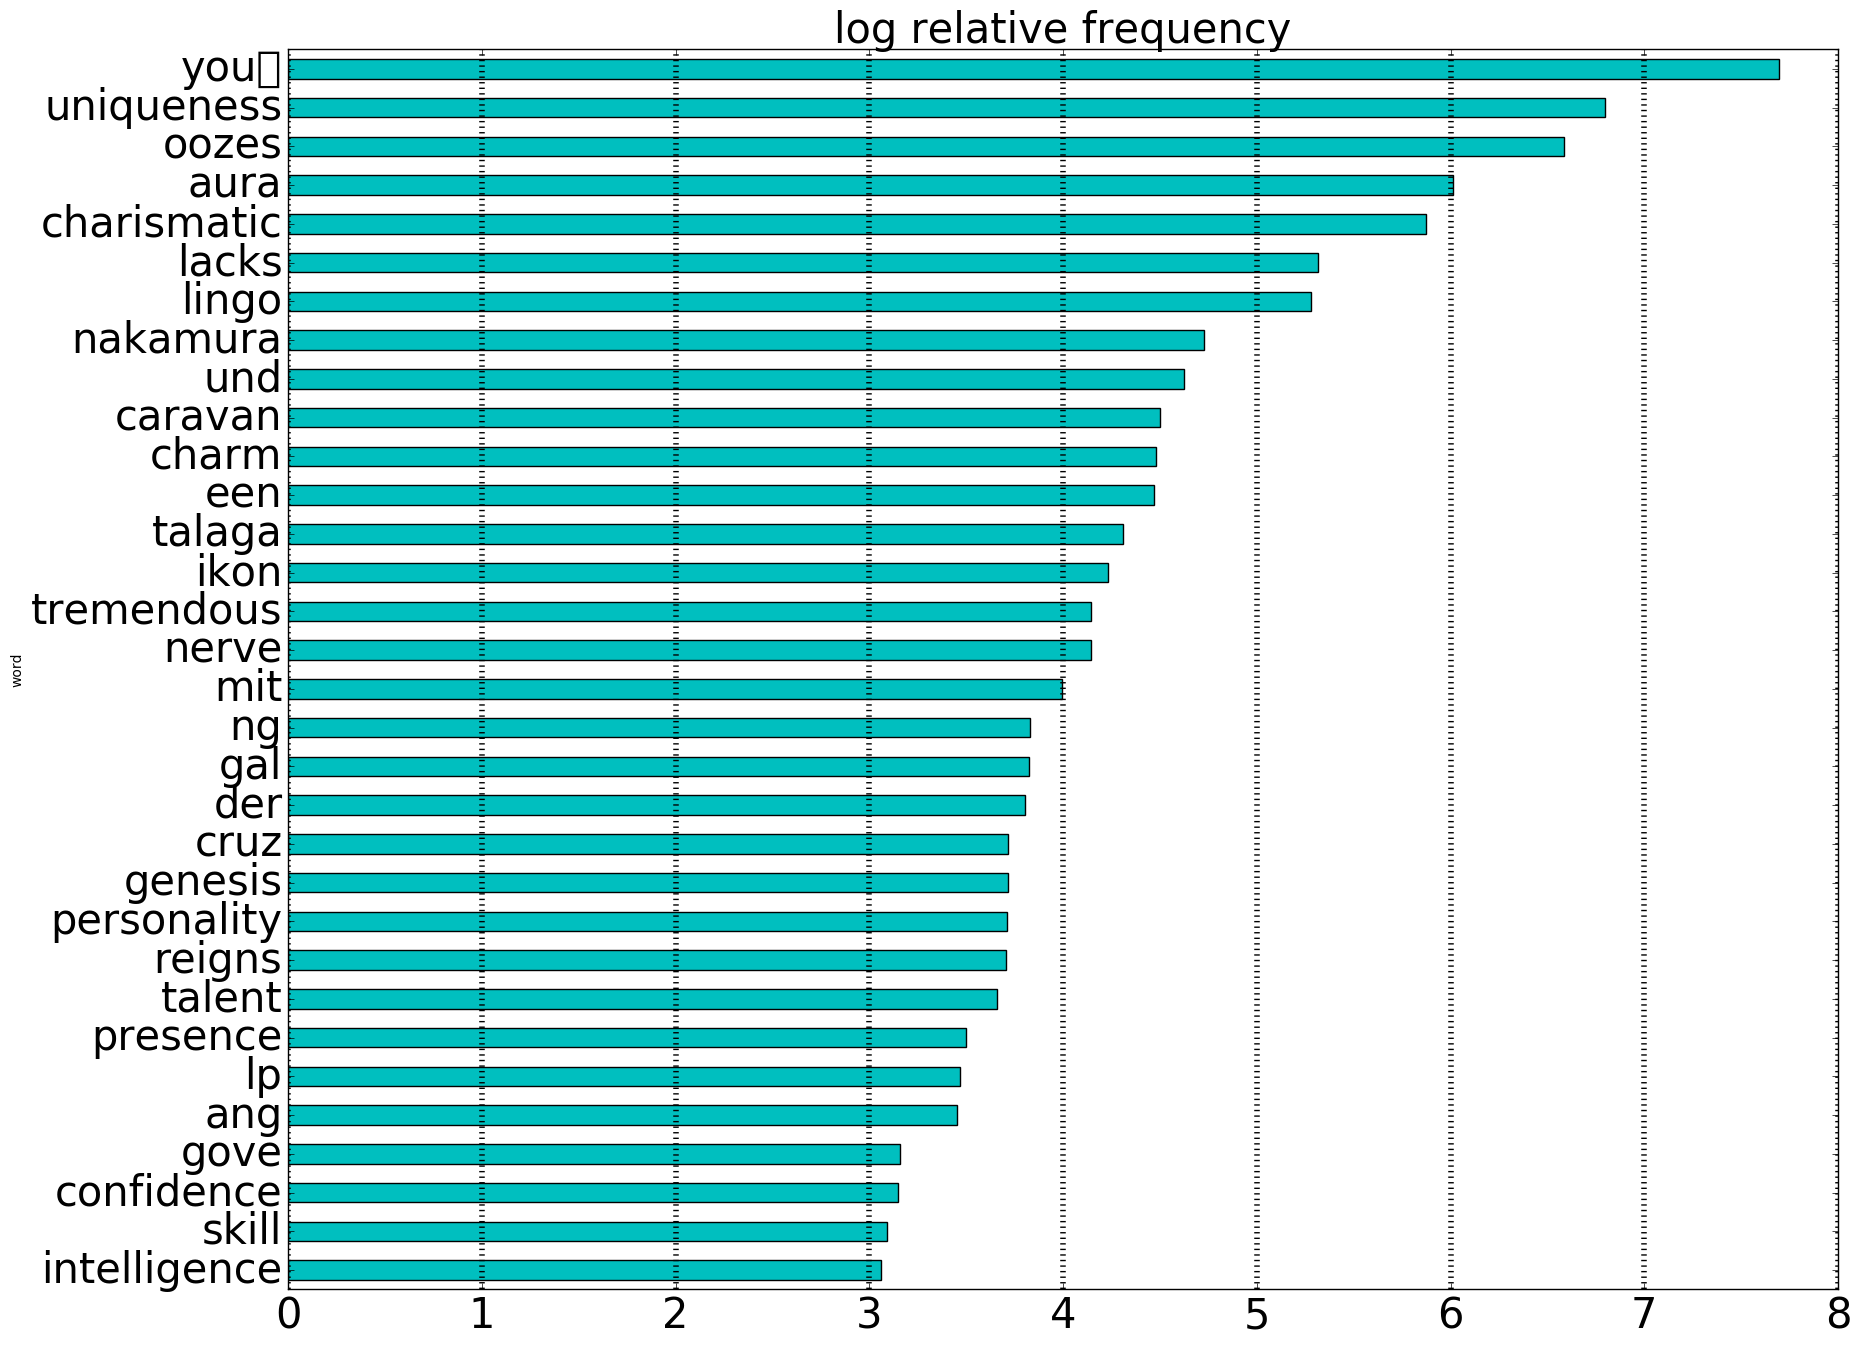

In [29]:
num_words_to_plot = 32
twit.word_freq_df.set_index("word")["log relative frequency"][-num_words_to_plot:].plot.barh(figsize=(20,
                num_words_to_plot/2.), fontsize=30, color="c"); 
plt.title("log relative frequency", fontsize=30); 
ax = plt.axes();        
ax.xaxis.grid(linewidth=4);

In [30]:
twit.word_freq_df.sort_values("log relative frequency", ascending=False, inplace=True)
twit.word_freq_df.head(12)

,word,occurrences,frequency,relative frequency,log relative frequency,background_occur
163,you！,687,0.000579,2202.135175,7.697183,19
98,uniqueness,957,0.000806,896.683997,6.798704,65
328,oozes,416,0.000350,723.879244,6.584625,35
38,aura,1690,0.001423,408.438810,6.012342,252
155,charismatic,707,0.000595,355.856482,5.874528,121
73,lacks,1113,0.000937,203.559684,5.315959,333
205,lingo,606,0.000510,196.315962,5.279725,188
375,nakamura,378,0.000318,112.850236,4.726062,204
266,und,480,0.000404,101.859181,4.623591,287
384,caravan,370,0.000312,90.136887,4.501329,250


It looks like we still have a lot of spam/repetive uninteresting content, but we can filter through and pick out interesting information. For example, we see the word "skill" is high in relative frequency: 

In [31]:
twit.tweets_containing("skill").head(12)

1862 tweets contain this term


,username,text
39,vrsvno,i am all set to witness the charisma and oratory skills of our pm at dav #davwelcomesmodi
48,papanemes,i'll take one order of adequate interpersonal skills please. and a side of charisma.
75,iiveinfear,"still hoping naomi becomes divas champion sometime in the future. she has the charisma, wrestling skills, and she can back up the talk. -"
119,drhousepls,"i'm shipping bayley and finn balor cause that would be top tier genetics for their kids. skill, charisma, abs, ass."
164,tresorgahungu,"charisma can take you to the door of your destiny. however, it is #integrity that will keep you there. #leadershipskills"
380,upper_cayce,@atinyangryman so people do put skills into anything other than charisma?!
425,bigwignation,what is physical charisma anyway? w jordan harbinger #confidence #help #social #skills
571,joseph_hoestar,i want to post selfies but euuhghg tfw ur charisma skill is 2 right now
785,salisburryatche,developing charisma skills – access is register: ipzlgsx
791,ikramlely,nak sthun dah..skill nak usha awek ni aku ade lagi tak..charisma aku ni dah drop ke..huhu..trok siall pangai..


It looks like people are often talking about charisma as a communication skill itself, as well as a way to hide a lack of skills elsewhere.

## Another anti-spam technique: filter out over-represented users
Find which users are contributing disproportionately to results 
with twit.tweets_df['username'].value_counts(), which returns a list of the users with highest number of tweets in descending order. These results can be plotted using something like twit.tweets_df['username'].value_counts().iloc[:0].plot.barh()

In [32]:
twit.tweets_df['username'].value_counts().head(12)

pcyhrr             657
av_momo            484
avranki            334
kindlebooks_4u     330
ukcaravancentre    255
dndskillcheck      235
martinlighthous    185
kvhanbin           139
beirutcallgirl     121
abubake19446198    116
zczzzcz            110
realhumanpraise    105
Name: username, dtype: int64

This shows that a few users are responsible for hundreds of tweets in our data set - this can be a problem, as we saw in twit.word_freq_df that many of our overly-frequent terms only had several hundred example in the data set. To see an example of the problem, we look at all the tweets by the most prolific charisma tweeter, user pcyhrr:

In [33]:
twit.tweets_by("pcyhrr").head(12)

,username,text
78318,pcyhrr,charisma_hanbin: rt alnikon_: yunhyeong and chanwoo at hamdeok beach 160525 ©n____ht pic.twitter.com/4le6dg4osb
78319,pcyhrr,charisma_hanbin: errrrr95 ขอราคาน่ารักๆ55555555
78320,pcyhrr,charisma_hanbin: [ikon - 2015-2016 ikoncert 'showtime' in seoul live dvd] pre-order : 31st may 2016 release : 21st june 2016 #ikon #ikonc…
78321,pcyhrr,charisma_hanbin: ikon - 2015-2016 ikoncert 'showtime' in seoul live dvd #ikon #아이콘
78322,pcyhrr,charisma_hanbin: rt ygent_official: [ikon - 2015-2016 ikoncert 'showtime' in seoul live dvd] 2016. 05. 31 pre-orde… …
78505,pcyhrr,charisma_hanbin: rt bapcha_: [father & i] press conference will be aired live on daum tvpot & kakao tv on this fri… pic.twitter.com/yjgjldt11d
78876,pcyhrr,charisma_hanbin: yg_ikonic 잘자애들
78946,pcyhrr,charisma_hanbin: rt triplekimcrown: โปรเจ็คเล็ก ๆ เพื่อ support triple kim จากบ้านของเราค่ะ หวังว่าทุกคนจะสนใจ และ… pic.twitter.com/mi6qa6g82y
78947,pcyhrr,charisma_hanbin: rt hanbin_th: มาสั่งเสื้อกันเร้วววววว สั่งได้ถึง 18 มิถุนายนนี้เท่านั้นนะคะ รายได้ทั้งหมดจะโดเนทเข้าโปรเจค #ikoncertinbang…
79564,pcyhrr,charisma_hanbin: babe~ #bi #ikon #hanbin cr.guard binpic.twitter.com/wtucsubgz7


It looks like this user is repeatedly tweeting at or about charisma_hanbin: we definitely want to drop his tweets. 


As another example we look at second most prolific charisma tweeter, av_momo: 

In [34]:
twit.tweets_by("av_momo").head(12)

,username,text
1417,av_momo,charisma gal get you！ 15 楓ゆうか ミニマムなちいさいカラダに反比例したでっかいオーラは 今時 gal！ pic.twitter.com/kpdhspfqgv
1442,av_momo,charisma gal get you！ 15 楓ゆうか ミニマムなちいさいカラダに反比例したでっかいオーラは今時 gal！ pic.twitter.com/ahc0imphvr
1486,av_momo,charisma gal get you！ 15 楓ゆうか ミニマムなちいさいカラダに反比例したでっかいオーラは今時 gal！ pic.twitter.com/qp6xndi2ts
1770,av_momo,kira★kira debut fcup美巨乳リアルgal専属デビュー charisma gal降臨 有村リア pic.twitter.com/lx5en7dqvd
2268,av_momo,charisma gal get you！ 15 楓ゆうか ミニマム なちいさいカラダに反比例したでっかいオーラは今時 ギャル！ pic.twitter.com/29pi61letk
2364,av_momo,kira★kira debut fcup美巨乳リアルgal専属デビュー charisma gal降臨 有村リア pic.twitter.com/djictqno7q
2877,av_momo,charisma gal get you！ 15 楓ゆうか ミニマムなちいさいカラダに反比例したでっかいオーラは 今時 gal！ pic.twitter.com/ti0ia9pzxu
2887,av_momo,charisma gal get you！ 15 楓ゆうか ミニマムなちいさいカラダに反比例したでっかいオーラは今時 gal！ pic.twitter.com/fvdxecpmje
2965,av_momo,charisma gal get you！ 15 楓ゆうか ミニマムなちいさいカラダに反比例したでっかいオーラは今時 gal！ pic.twitter.com/sion1iy2hg
3085,av_momo,kira★kira debut fcup美巨乳リアルgal専属デビュー charisma gal降臨 有村リア pic.twitter.com/g5kb4bx9d3


This is again repetive and uninteresting data that we wish to drop. 

To facilitate dropping users who tweet repeatedly we can use the function drop_by_username_with_n_tweets, which drops all tweets by users that have more than n tweets in our dataset. To be sure we filter out all offenders, here we will use n=1: 

In [35]:
twit.drop_by_username_with_n_tweets(1)

Dropping tweets by repeated users...
Found 13450 users with more than 1 tweets in tweets_df
Finished 0 percent of user drops
Finished 5 percent of user drops
Finished 10 percent of user drops
Finished 15 percent of user drops
Finished 20 percent of user drops
Finished 25 percent of user drops
Finished 30 percent of user drops
Finished 35 percent of user drops
Finished 40 percent of user drops
Finished 45 percent of user drops
Finished 50 percent of user drops
Finished 55 percent of user drops
Finished 60 percent of user drops
Finished 65 percent of user drops
Finished 70 percent of user drops
Finished 75 percent of user drops
Finished 80 percent of user drops
Finished 85 percent of user drops
Finished 90 percent of user drops
Finished 95 percent of user drops
Finished 100 percent of user drops
Took 9.293 minutes to complete


In [36]:
# now recompute word bag and word frequency objeect and look at results
twit.create_word_bag()
twit.make_nltk_object_from_word_bag()

Time to make words_string:  0.001 minutes
Time to tokenize:  0.428 minutes
Time to compute word bag:  0.12 minutes


In [38]:
twit.create_word_freq_df(400)

Creating word_freq_df...
Takes about 1 minute per 1000 words
Time to create word_freq_df:  0.2346 minutes


In [39]:
twit.word_freq_df.sort_values("log relative frequency", ascending = True, inplace = True)

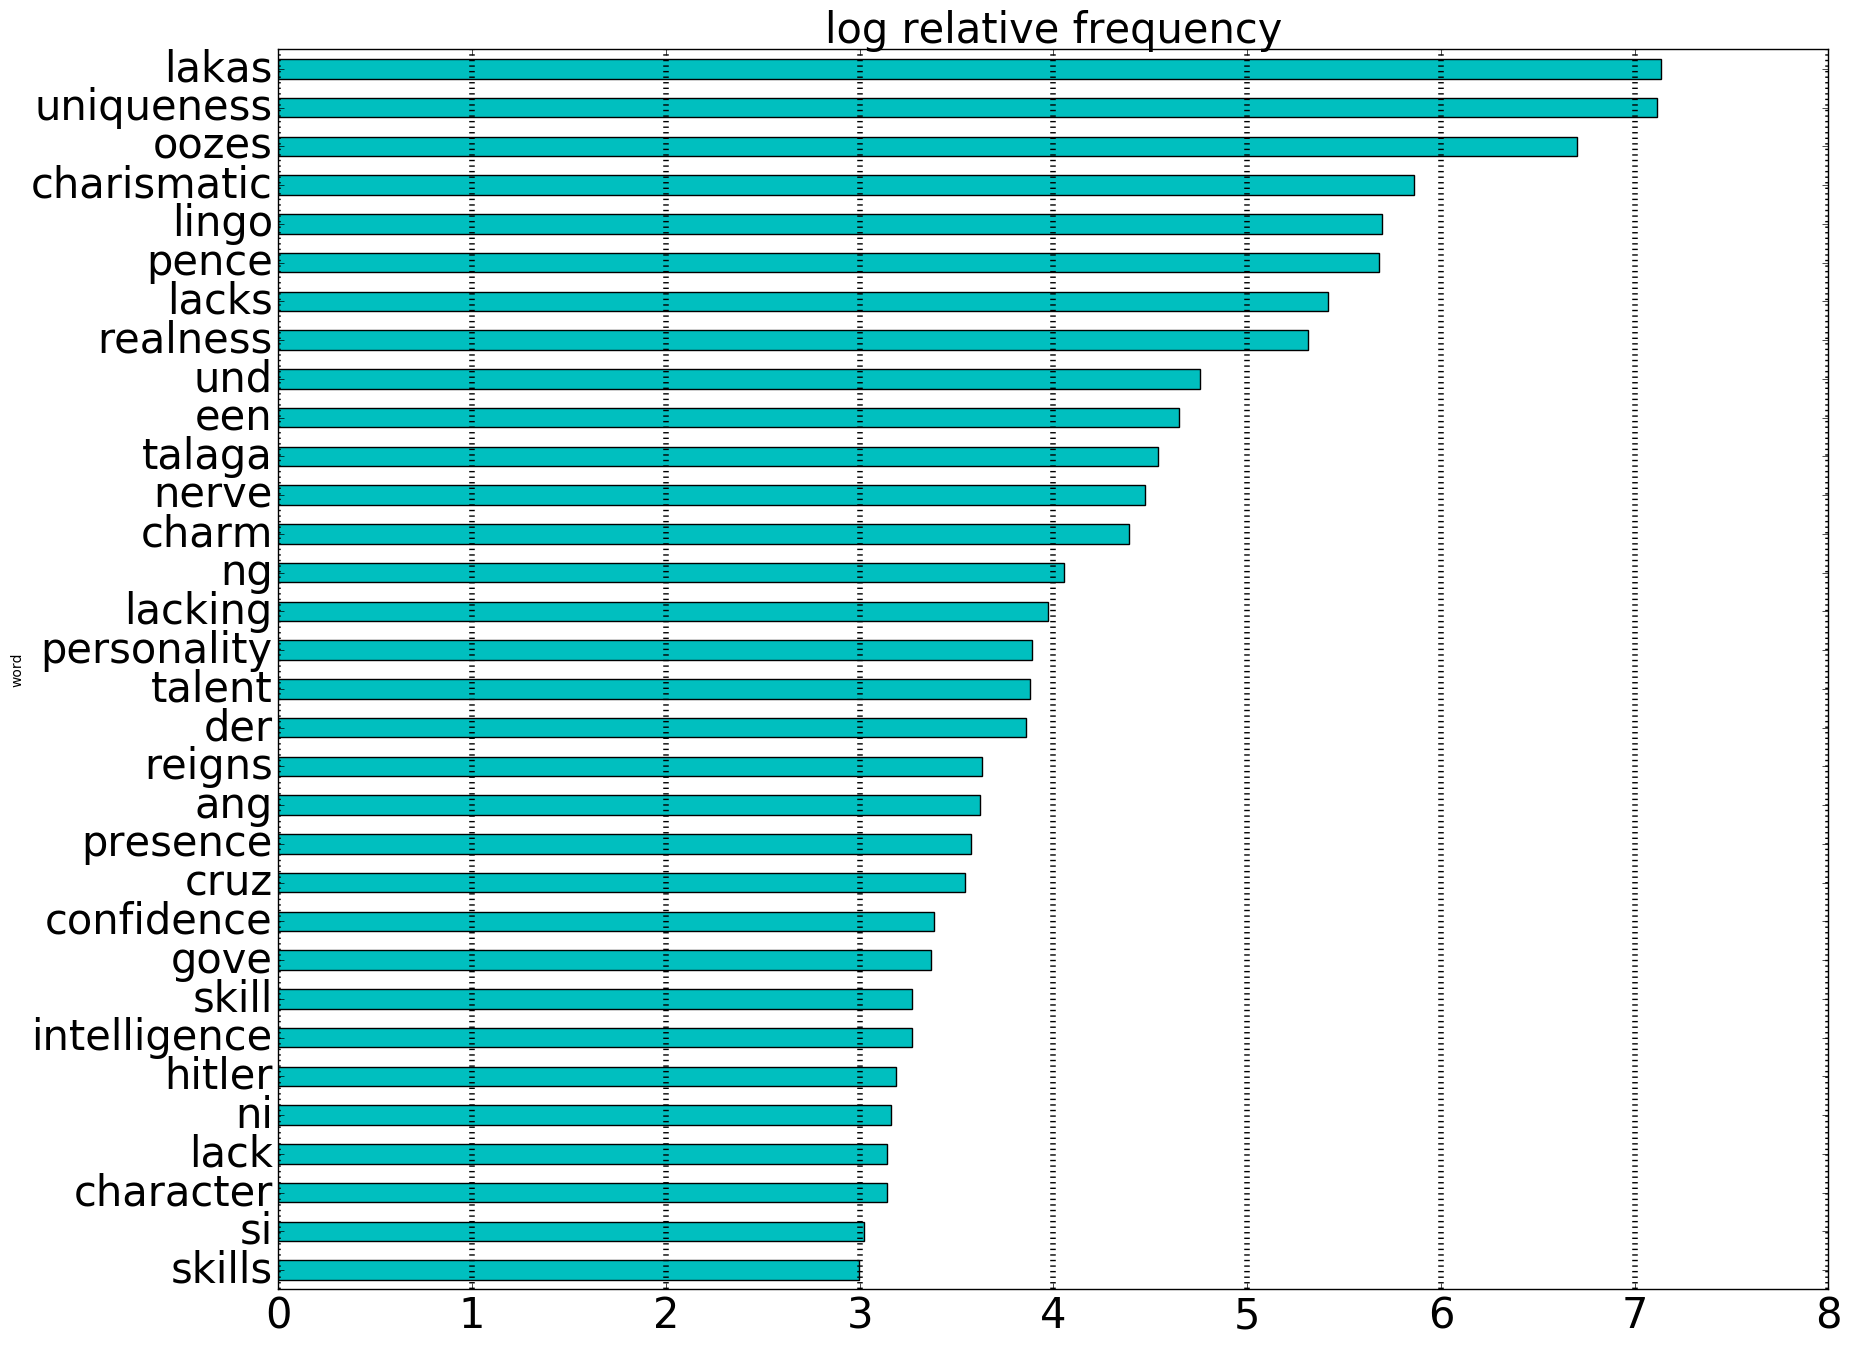

In [40]:
num_words_to_plot = 32
twit.word_freq_df.set_index("word")["log relative frequency"][-num_words_to_plot:].plot.barh(figsize=(20,
                num_words_to_plot/2.), fontsize=30, color="c"); 
plt.title("log relative frequency", fontsize=30); 
ax = plt.axes();        
ax.xaxis.grid(linewidth=4);

### Remove words that don't appear frequently enough in background

We see from this example that not removing rare background examples can cause problems: the word "lakas" appears only 19 times in background, and because of this it is now the number one word in frequency dataframe. We see a similar pattern with a number of other top words. 

In [61]:
twit.word_freq_df.sort_values("log relative frequency", ascending=False).head(10)

,word,occurrences,frequency,relative frequency,log relative frequency,background_occur
363,lakas,231,0.000331,1258.254912,7.137481,19
59,uniqueness,774,0.001108,1232.360755,7.116687,65
846,spritzer,108,0.000155,1117.722545,7.019048,10
294,oozes,275,0.000394,813.157937,6.700925,35
705,nicht,128,0.000183,662.354101,6.495800,20
922,exudes,99,0.000142,602.693529,6.401409,17
944,niet,96,0.000137,551.961751,6.313479,18
1451,likability,63,0.000090,543.337349,6.297730,12
2071,noch,41,0.000059,530.400745,6.273633,8
1664,mehr,53,0.000076,498.647264,6.211899,11


We see that the most common words all have background occurrences smaller than 100 - this may collect rarer words that we are not interested in.

To correct for this we can remove words from consideration that don't appear often enough in background. 

We'll do this by first creating a word_freq_df with many top words (10,000 here) and then filtering out words that don't have a frequent enough background rate before plotting.

In [53]:
twit.create_word_freq_df(10000)

Creating word_freq_df...
Takes about 1 minute per 1000 words
Time to create word_freq_df:  5.304 minutes


Filter out words that occur less than 100 times in background: 

In [71]:
twit.word_freq_df[twit.word_freq_df["background_occur"]>100].sort_values("log relative frequency", ascending=False).head(10)

,word,occurrences,frequency,relative frequency,log relative frequency,background_occur
167,charismatic,410,0.000587,350.678178,5.859869,121
111,lingo,540,0.000773,297.266634,5.694629,188
68,lacks,725,0.001038,225.322224,5.417531,333
297,realness,273,0.000391,203.262893,5.314500,139
408,overflowing,208,0.000298,182.428036,5.206356,118
660,topgear,140,0.000200,128.221203,4.853757,113
230,und,323,0.000462,116.474507,4.757672,287
709,lacked,126,0.000180,116.429432,4.757285,112
439,het,196,0.000280,113.958395,4.735833,178
628,swagger,147,0.000210,104.920316,4.653201,145


Now plot the word frequencies using altered word_freq_df: 

### At least 100 background occurrences:

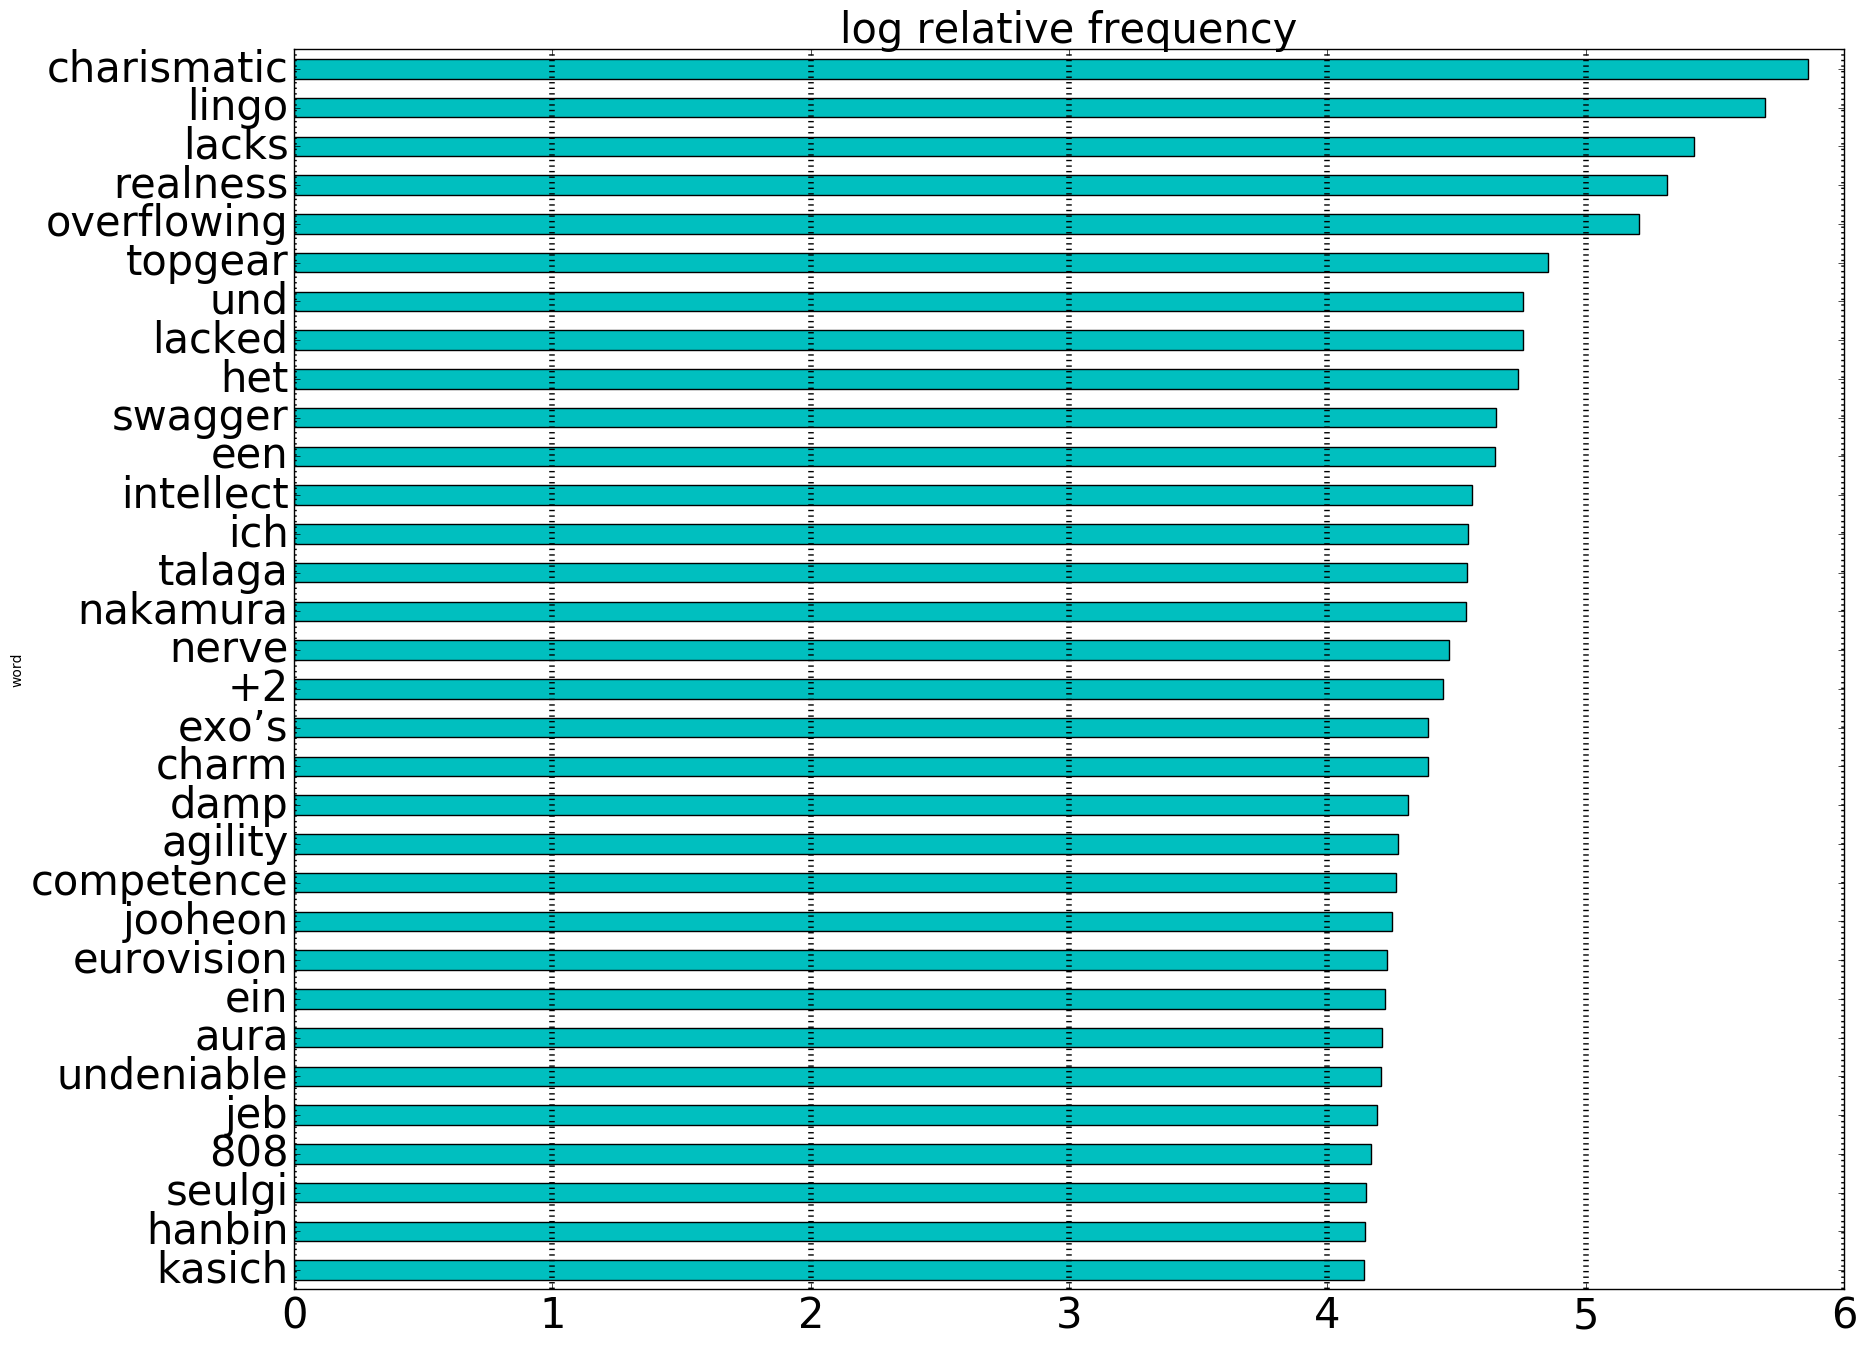

In [68]:
num_words_to_plot = 32
background_cutoff = 100
twit.word_freq_df[twit.word_freq_df["background_occur"]>background_cutoff].sort_values("log relative frequency", ascending=True).set_index("word")["log relative frequency"][-num_words_to_plot:].plot.barh(figsize=(20,
                num_words_to_plot/2.), fontsize=30, color="c"); 
plt.title("log relative frequency", fontsize=30); 
ax = plt.axes();        
ax.xaxis.grid(linewidth=4);

We can further explore by setting an even higher bound on background words: 

#### At least 500 background occurrences:

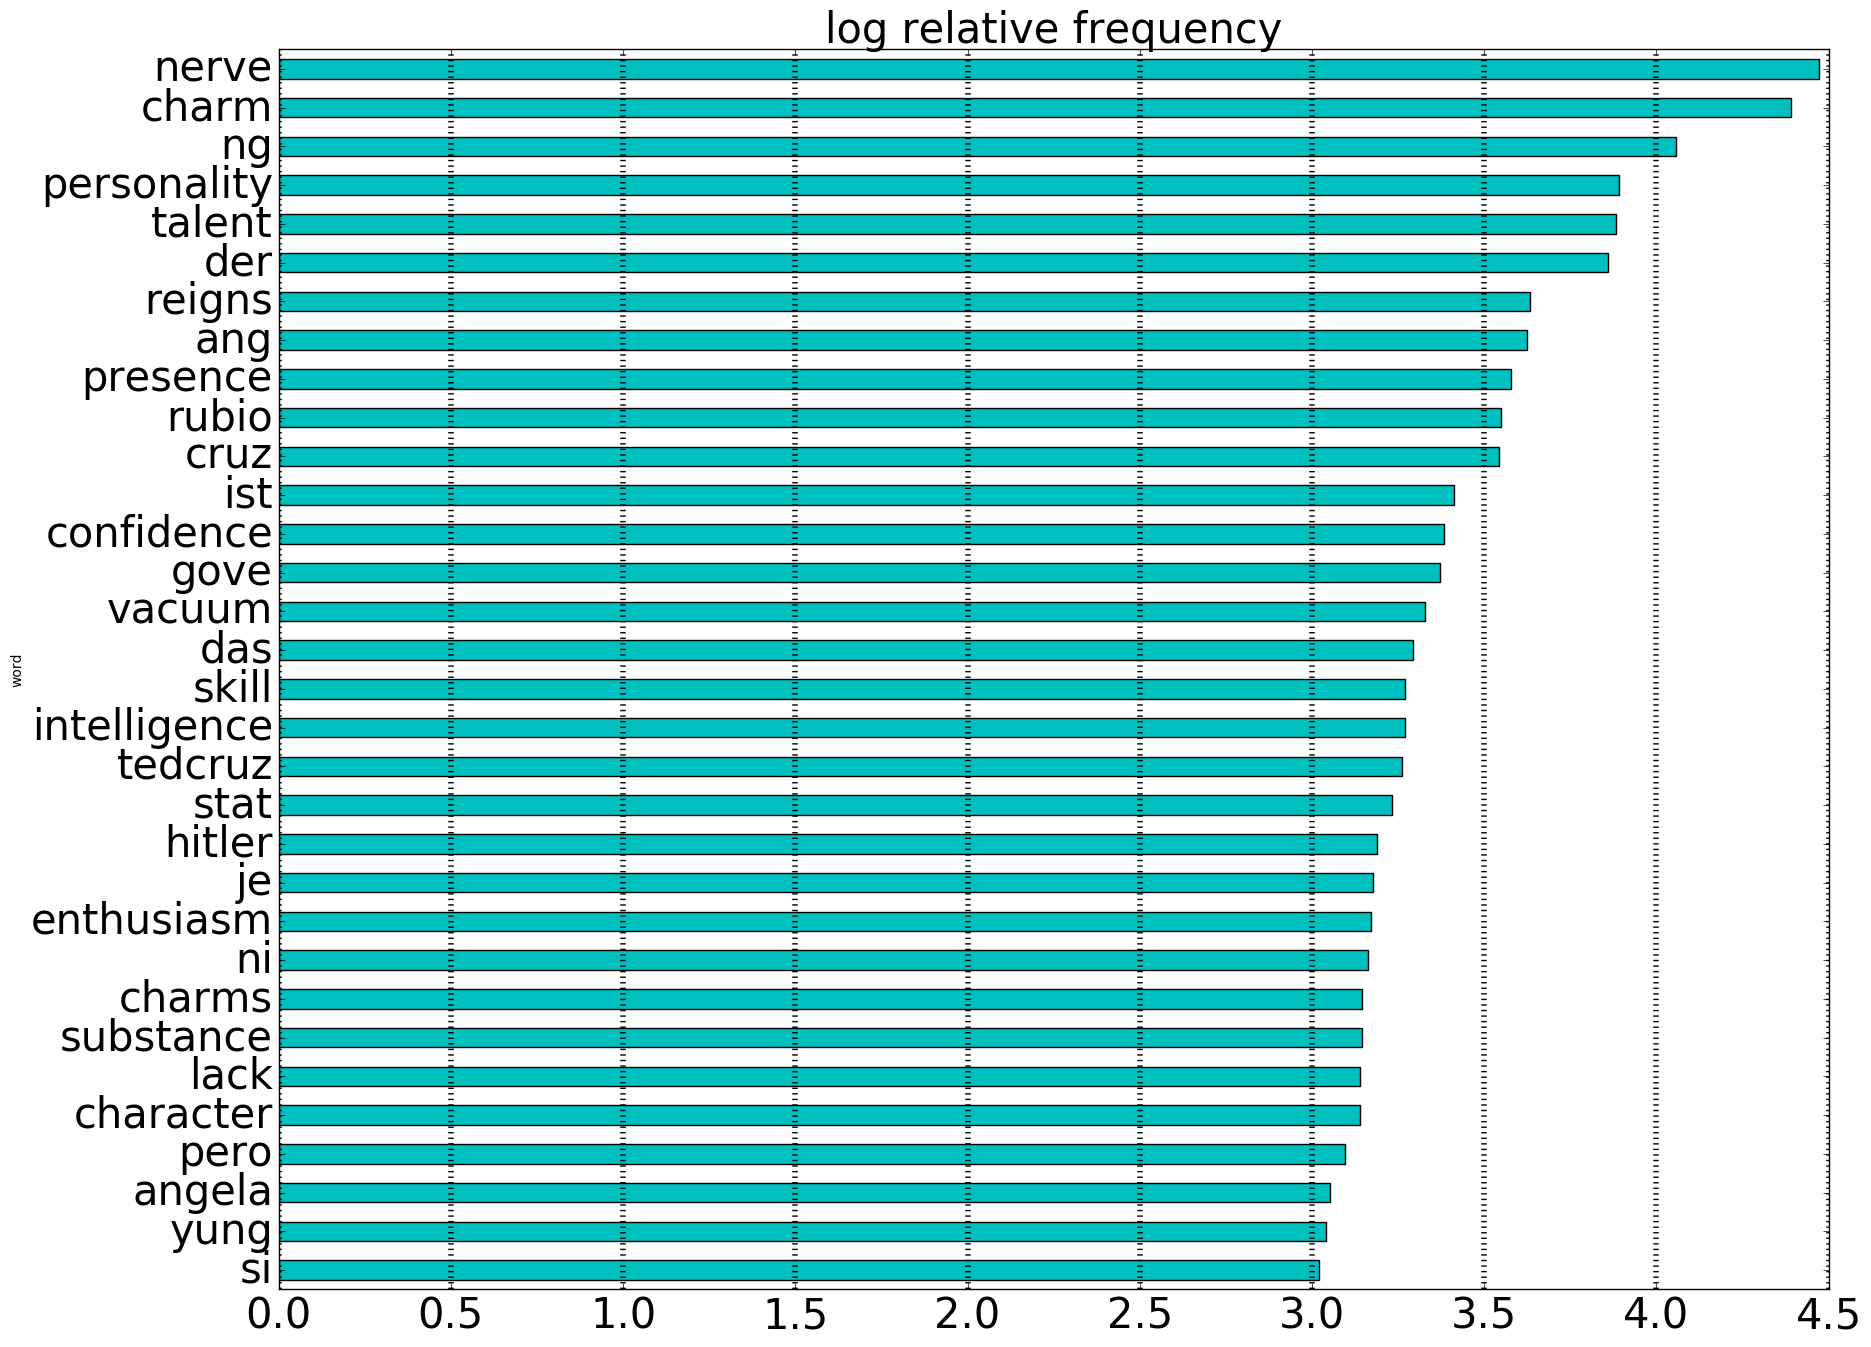

In [69]:
num_words_to_plot = 32
background_cutoff = 500
twit.word_freq_df[twit.word_freq_df["background_occur"]>background_cutoff].sort_values("log relative frequency", ascending=True).set_index("word")["log relative frequency"][-num_words_to_plot:].plot.barh(figsize=(20,
                num_words_to_plot/2.), fontsize=30, color="c"); 
plt.title("log relative frequency", fontsize=30); 
ax = plt.axes();        
ax.xaxis.grid(linewidth=4);

#### At least 2000 background occurrences:

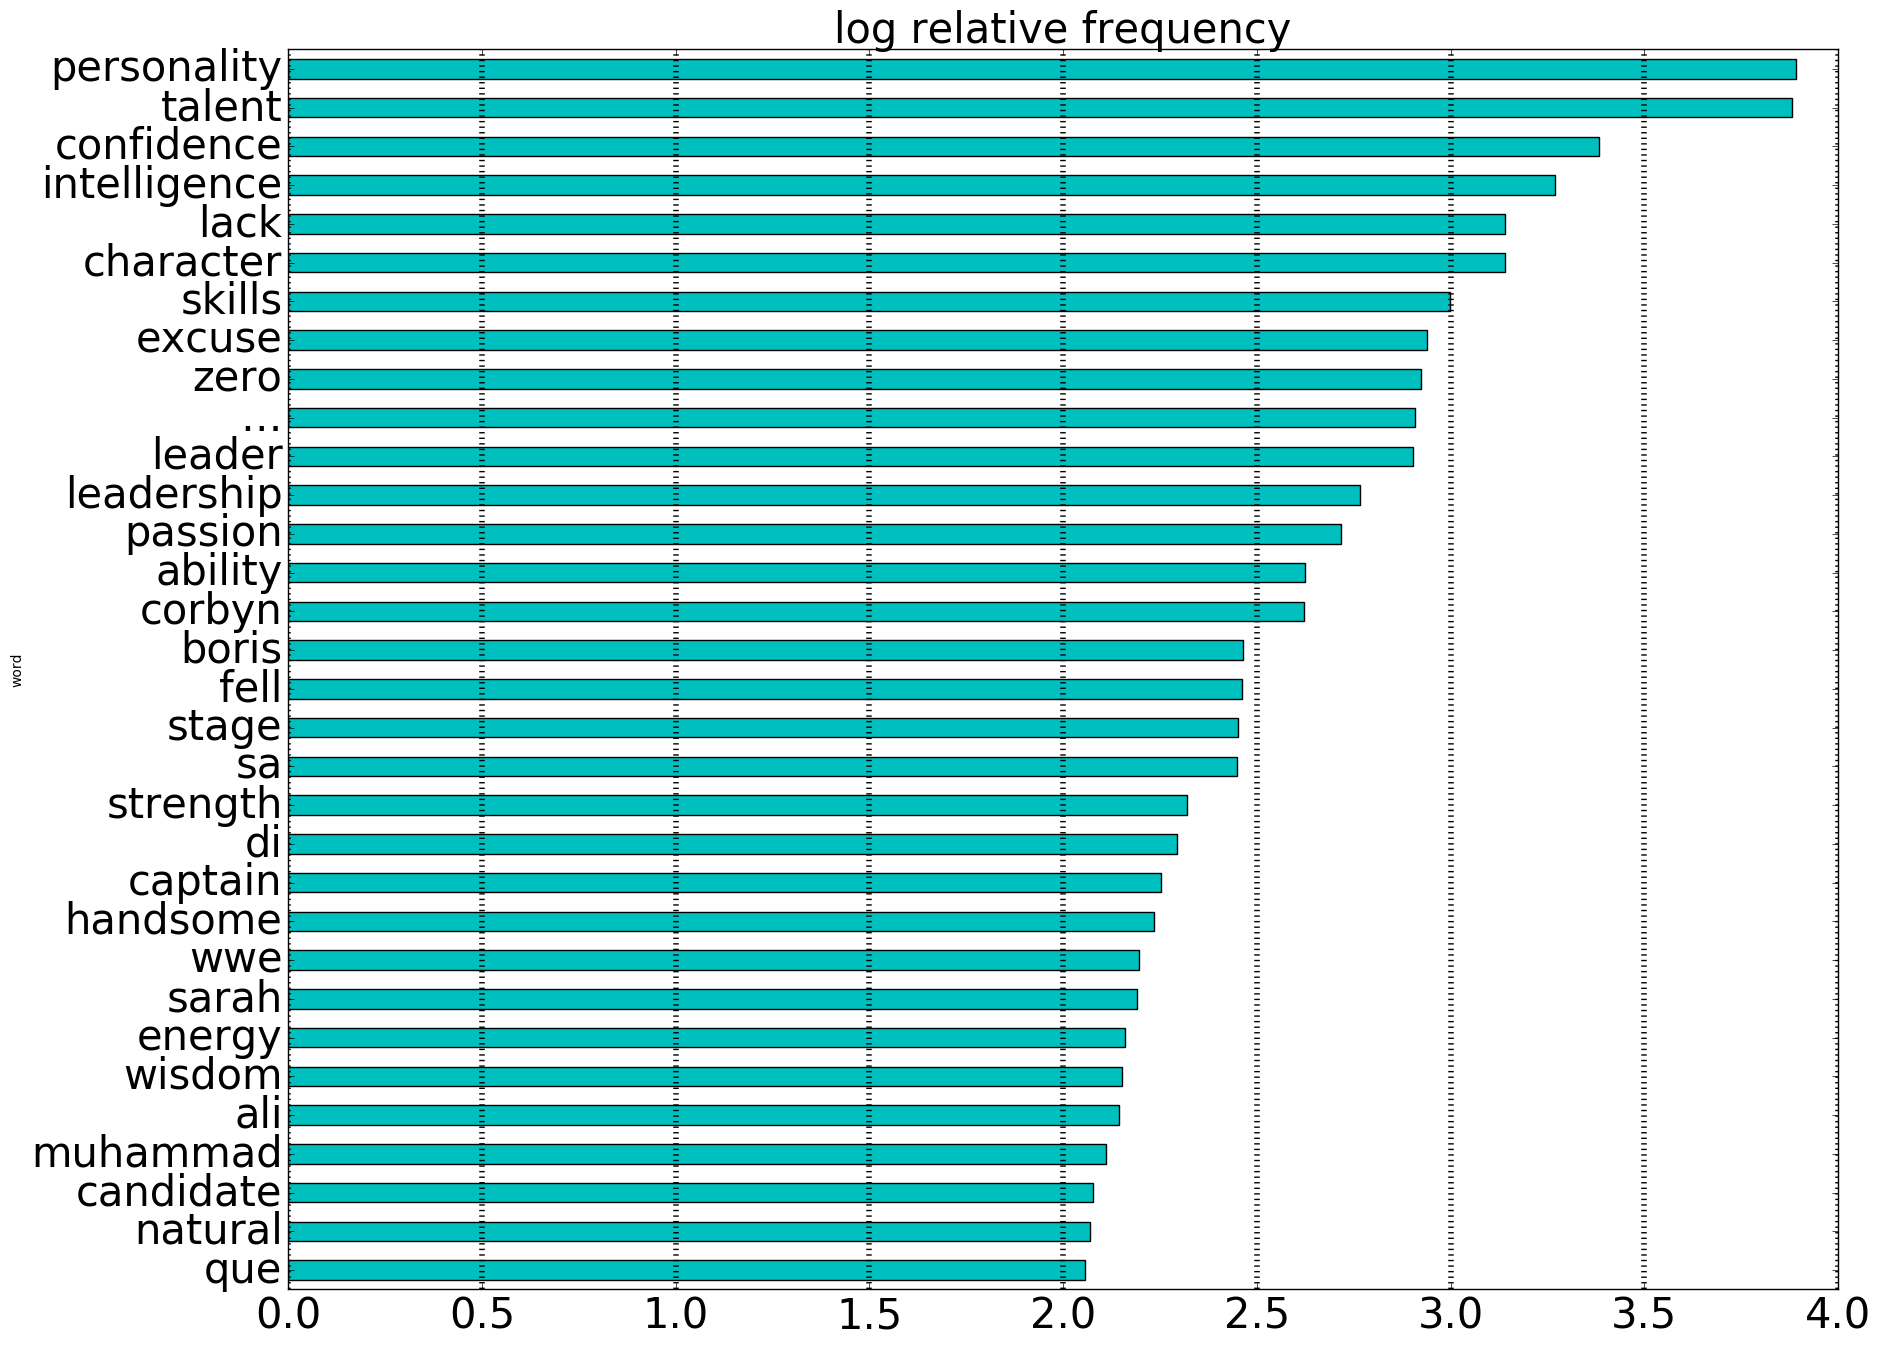

In [70]:
num_words_to_plot = 32
background_cutoff = 2000
twit.word_freq_df[twit.word_freq_df["background_occur"]>background_cutoff].sort_values("log relative frequency", ascending=True).set_index("word")["log relative frequency"][-num_words_to_plot:].plot.barh(figsize=(20,
                num_words_to_plot/2.), fontsize=30, color="c"); 
plt.title("log relative frequency", fontsize=30); 
ax = plt.axes();        
ax.xaxis.grid(linewidth=4);

#### At least 10000 background occurrences:

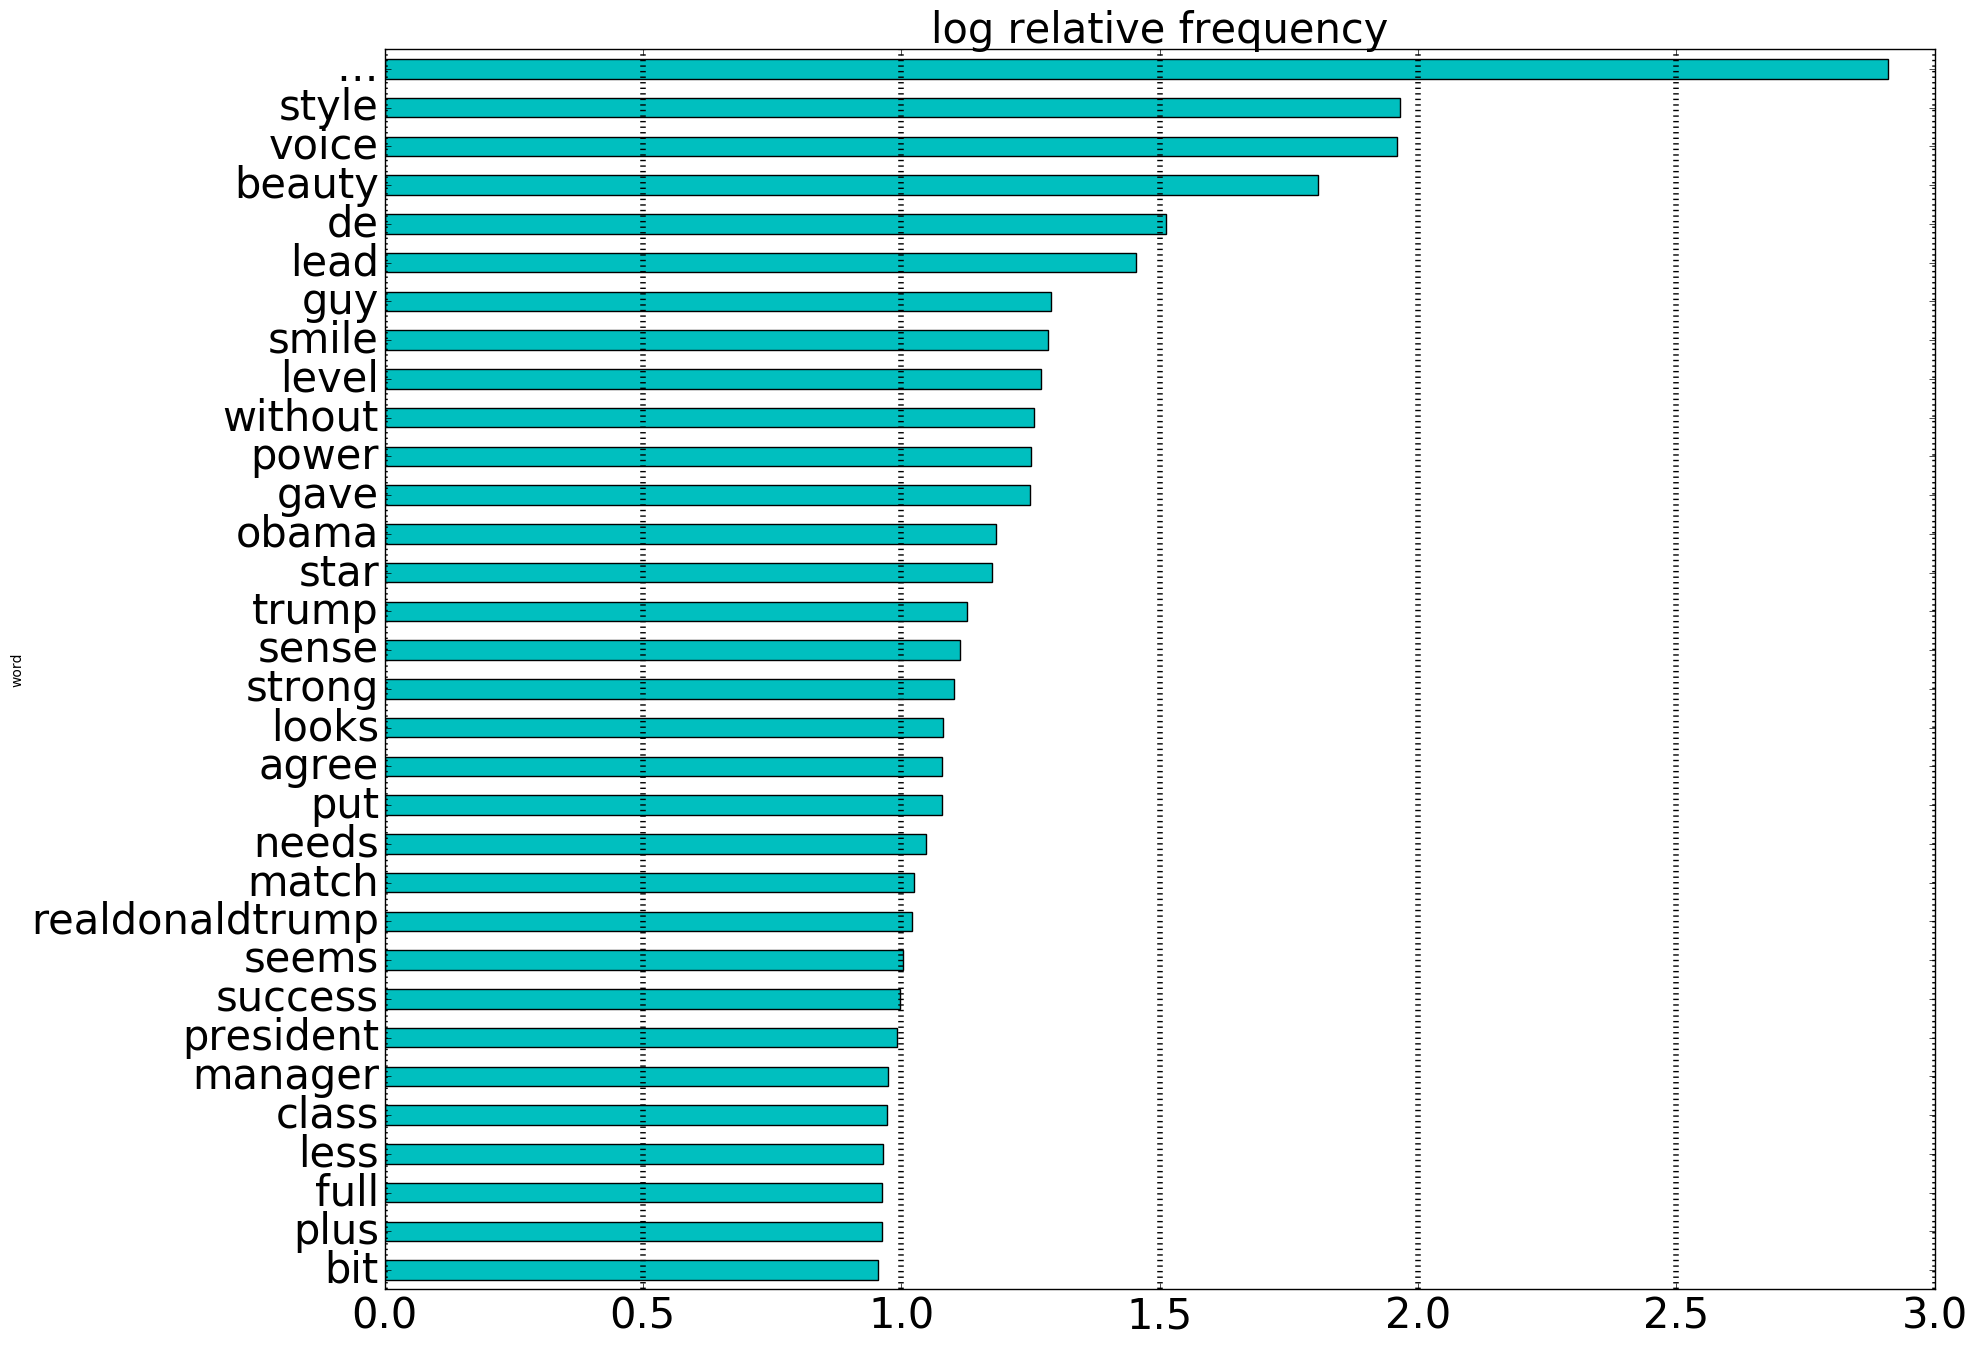

In [72]:
num_words_to_plot = 32
background_cutoff = 10000
twit.word_freq_df[twit.word_freq_df["background_occur"]>background_cutoff].sort_values("log relative frequency", ascending=True).set_index("word")["log relative frequency"][-num_words_to_plot:].plot.barh(figsize=(20,
                num_words_to_plot/2.), fontsize=30, color="c"); 
plt.title("log relative frequency", fontsize=30); 
ax = plt.axes();        
ax.xaxis.grid(linewidth=4);

From this casual investigation a background cutoff of around 2000 occurrences appears to pick out the type of semantically interesting words we're looking for. The background cutoff will depend on the application, quality of background tweets, etc.

## One last issue: language detection

As we saw above, sometimes we would get a number of tweets that were not in English, which might not be of interest. The python library langdetect can classify languages of tweets accurately, but it can only do ~2500 tweets per minutes, which works out to several hours for this charisma dataset. It may be worth it if it is found other languages are cluttering out the English words too much - here is example how how it can be applied.

In [41]:
smaller_charisma_df = twit.tweets_df[0:100].copy()

In [42]:
from langdetect import detect
import time

In [43]:
# this can take a while
start_time = time.time()
smaller_charisma_df["lang"] = smaller_charisma_df["text"].map(detect)
print "Took", round((time.time() - start_time)/60., 2), "minutes to compute"
sec_per_tweet = (time.time() - start_time)/float(len(smaller_charisma_df))
print "Took on average", round(sec_per_tweet,2), "seconds per tweet"
print "Can classify", round(60./sec_per_tweet,2), "tweets by language per minute"

Took 0.07 minutes to compute
Took on average 0.04 seconds per tweet
Can classify 1414.51 tweets by language per minute


This gives us a new column in our dataframe called "lang" that has abbreviation for predicted languages of each tweet.

If we want to keep only the tweets classifying as English ("en"), we can do this: 

In [44]:
smaller_charisma_df = smaller_charisma_df[smaller_charisma_df['lang'] == 'en']

In [45]:
smaller_charisma_df.head(4)

,username,date,retweets,favorites,text,mentions,hashtags,id,permalink,lang
0,zayhitz,2016-02-13,0,0,got so much charisma what's the program? #evol,NaN,#evol,698728296922685440,https://twitter.com/ZayHitz/status/698728296922685440,en
1,nickpollak,2016-02-13,3,14,ben carson has the charisma of a toothbrush,NaN,NaN,698715913605013504,https://twitter.com/NickPollak/status/698715913605013504,en
2,totallytuesday,2016-02-13,0,0,#gopdebate #tytlive #feelthebern ben's cray cray has no charisma,NaN,#gopdebate #tytlive #feelthebern,698715988192206850,https://twitter.com/totallytuesday/status/698715988192206850,en
3,krock2step,2016-02-13,1,1,the westminster dog show has more personality and charisma than these presidential debates,NaN,NaN,698716287061647362,https://twitter.com/krock2step/status/698716287061647362,en


In [46]:
len(smaller_charisma_df)

94